## Environment Setting

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip

In [3]:
!unzip -qq IAM_Words.zip

In [4]:
!mkdir data
!mkdir data/words

In [5]:
!tar -xf IAM_Words/words.tgz -C data/words

In [6]:
!mv IAM_Words/words.txt data

## Importing Libraries

In [9]:
import numpy as np
import os
from os import listdir
import re
import pickle
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.python.ops.numpy_ops import np_config
import matplotlib.pyplot as plt
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)

## Exploring and processing Data

In [10]:
!head -25 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE
a01-000u-00-02 ok 154 796 764 70 50 TO to
a01-000u-00-03 ok 154 919 757 166 78 VB stop
a01-000u-00-04 ok 154 118

In [11]:
base_path = "/content/data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] =="#":
        continue
    if line.split(" ")[1] != "err":
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [12]:
words_list

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n',
 'g06-050k-00-07 ok 156 1842 717 85 76 PP$ his\n',
 'm01-100-01-06 ok 185 1459 880 177 131 JJ flying\n',
 'n02-033-04-01 ok 149 940 1486 353 85 VBD presented\n',
 'p03-047-00-01 ok 191 393 739 127 80 UH No\n',
 'g06-011e-08-00 ok 154 386 2190 70 44 CS as\n',
 'p02-000-00-02 ok 182 752 727 97 85 AP few\n',
 'c01-009-08-03 ok 182 1387 2363 170 81 NN work\n',
 'c04-156-01-04 ok 175 989 912 65 142 INO of\n',
 'h02-004-09-01 ok 191 776 2424 191 76 NNS items\n',
 'g06-037o-03-02 o

In [13]:
# Splitting the dataset into three subsets with a 90:5:5 ratio (train:validation:test)
split_idx = int(0.9*len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total Training Samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total Training Samples: 86810
Total validation samples: 4823
Total test samples: 4823


## Data Input Pipline

In [14]:
base_image_path = os.path.join(base_path, "words")
print(base_path)
def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

/content/data


In [15]:
train_img_paths[0:10]

['/content/data/words/e04/e04-030/e04-030-04-08.png',
 '/content/data/words/k02/k02-102/k02-102-05-03.png',
 '/content/data/words/a01/a01-082u/a01-082u-01-04.png',
 '/content/data/words/m01/m01-000/m01-000-07-00.png',
 '/content/data/words/g01/g01-031/g01-031-07-06.png',
 '/content/data/words/f07/f07-081b/f07-081b-01-06.png',
 '/content/data/words/n03/n03-082/n03-082-04-03.png',
 '/content/data/words/g06/g06-018c/g06-018c-04-05.png',
 '/content/data/words/g06/g06-011j/g06-011j-06-06.png',
 '/content/data/words/f04/f04-024/f04-024-01-06.png']

## Testing Data Input Pipline

In [16]:
!unrar e "/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs.rar" "/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs.rar

Extracting  /content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word0.jpg       1%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word1.jpg       3%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word2.jpg       5%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word3.jpg       6%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word4.jpg       8%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line10word0.jpg       9%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/OCR/Hand wri

In [17]:
base_image_path = os.path.join(base_path, "/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs")
print(base_image_path)

t_images = []
for f in listdir(base_image_path):
    t_images_path = os.path.join(base_image_path, f)
    t_images.append(t_images_path)

print(t_images)

/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs
['/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word0.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word1.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word2.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word3.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word4.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line10word0.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line10word1.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line1word0.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line1word1.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detecti

In [18]:
t_images[0:10]

['/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word3.jpg',
 '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line10word0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line10word1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line1word0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line1word1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line1word2.jpg']

In [19]:
def atoi(text):
    
    return int(text) if text.isdigit() else text

def natural_keys(text):

    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

t_images.sort(key=natural_keys)
print(t_images)

['/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word0.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word1.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word2.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word3.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line0word4.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line1word0.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line1word1.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line1word2.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line1word3.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/test_imgs/line1word4.jpg', '/content/drive/MyDrive/Colab Notebooks/OCR/Hand 

In [20]:
train_img_paths[0:10]

['/content/data/words/e04/e04-030/e04-030-04-08.png',
 '/content/data/words/k02/k02-102/k02-102-05-03.png',
 '/content/data/words/a01/a01-082u/a01-082u-01-04.png',
 '/content/data/words/m01/m01-000/m01-000-07-00.png',
 '/content/data/words/g01/g01-031/g01-031-07-06.png',
 '/content/data/words/f07/f07-081b/f07-081b-01-06.png',
 '/content/data/words/n03/n03-082/n03-082-04-03.png',
 '/content/data/words/g06/g06-018c/g06-018c-04-05.png',
 '/content/data/words/g06/g06-011j/g06-011j-06-06.png',
 '/content/data/words/f04/f04-024/f04-024-01-06.png']

In [21]:
train_labels[0: 10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

In [22]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label)) 
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [23]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [24]:
ff = list(characters)

In [27]:
with open("/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/characters", "rb") as fp:   
    b = pickle.load(fp)
    print(b)

['L', 'E', '"', '0', '2', 's', 'l', 'w', 'p', 'P', 'H', '/', 'O', 'V', 'f', '!', 'X', 'v', 'M', ':', 'N', '4', '3', "'", 'F', 'J', '(', 'K', '+', 'o', '#', 'I', 'r', '9', ',', '&', '8', 'B', '*', 'Q', 'g', '.', 'W', 'j', 'q', 'm', 'c', '5', ';', '7', 'U', 'h', 'u', 'a', ')', 'R', 'i', 'C', 'z', 'n', '-', 'Y', 'D', 'x', 'd', 'S', 'y', 'Z', 'e', 'k', 'G', '?', 'T', 'A', '6', 't', '1', 'b']


In [28]:
# Building the character vocabulary

AUTOTUNE = tf.data.AUTOTUNE

# Maping characaters to integers
char_to_num = StringLookup(vocabulary=b, mask_token=None)

# Maping integers back to original characters
num_to_chars = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [29]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height +1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
      image, paddings=[
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0, 0],
      ],
    )
    image = tf.transpose(image, perm=[1,0,2])
    image = tf.image.flip_left_right(image)
    return image

In [30]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
    process_images_labels, num_parallel_calls=AUTOTUNE
  )

    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [31]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

### Preparing new testing images

In [32]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def process_images_2(image_path):
    image = preprocess_image(image_path)
    return {"image": image}

def prepare_test_images(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths)).map(
    process_images_2, num_parallel_calls=AUTOTUNE
  )

    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

inf_images = prepare_test_images(t_images)

### Visualizing new test images

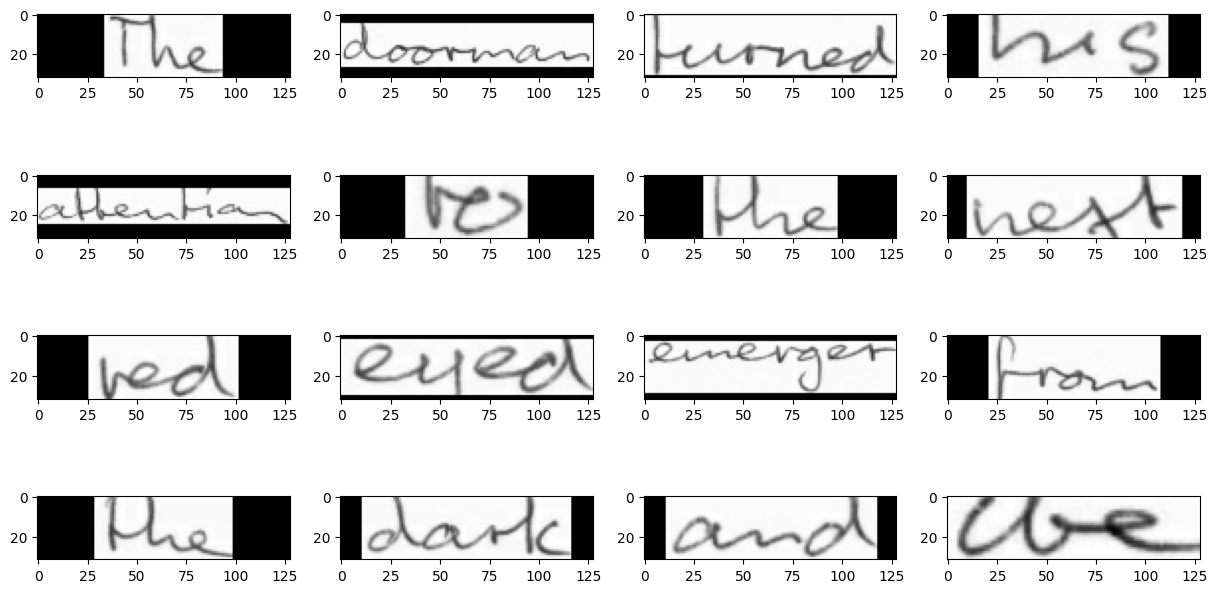

In [33]:
np_config.enable_numpy_behavior()

for data in inf_images.take(1):
    images = data["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        ax[i // 4, i % 4].imshow(img, cmap="gray")

    plt.show()

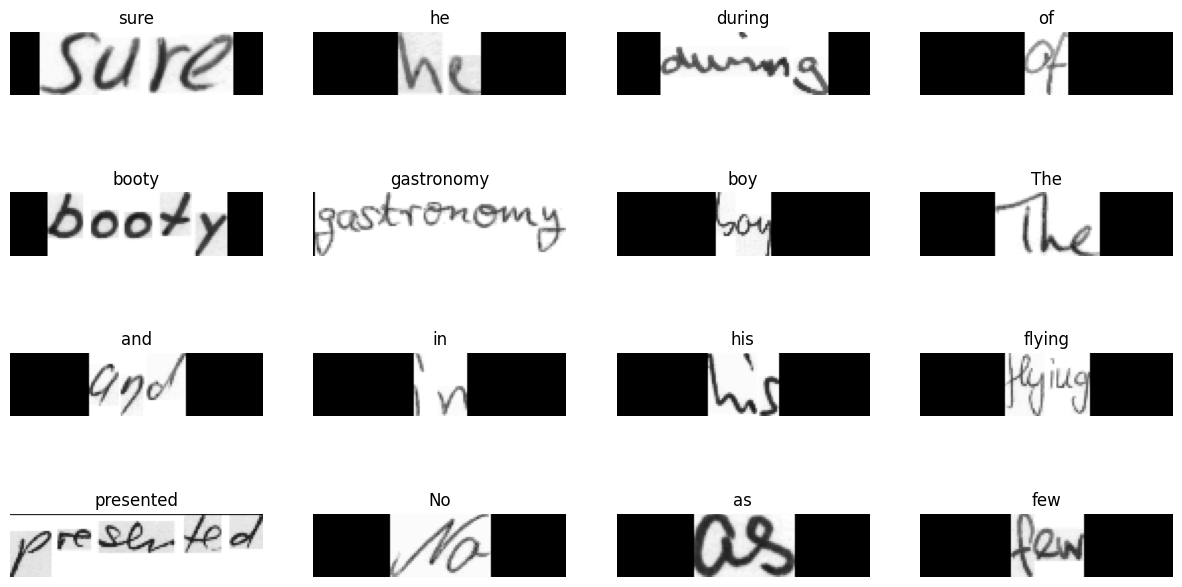

In [34]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        label = tf.strings.reduce_join(num_to_chars(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

    plt.show()

## Modeling

In [35]:
class CTCLayer(keras.layers.Layer):

    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

def build_model():

    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    x = keras.layers.Conv2D(
      32, (3,3), activation = "relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv1"
    )(input_img)
    x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)

    x = keras.layers.Conv2D(
      64, (3,3), activation = "relu", kernel_initializer="he_normal",
      padding="same",
      name="Conv2"
    )(x)
    x = keras.layers.MaxPooling2D((2,2), name="pool2")(x)

    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Bidirectional(
      keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
    keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    x = keras.layers.Dense(
    len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)

    # model definition
    model = keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # optimizer
    opt = keras.optimizers.Adam()
    # Compiling the model 
    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

## Evaluation Metrix

In [36]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [37]:
def calculate_edit_distance(labels, predictions):

    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
    predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
    tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    edit_distances = tf.edit_distance(
    sparse_predictions, sparse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model
    def on_epoch_end(self, epoch, logs = None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())
        print(f"Mean eidt distance for each {epoch + 1}: {np.mean(edit_distances): .4f}")

## Training

In [38]:
epochs = 50 

model = build_model()
prediction_model = keras.models.Model(
  model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  callbacks=[edit_distance_callback],
)

Epoch 1/50
1/1 [==============================] - 1s 1s/step
Mean eidt distance for each 1:  20.4404
1357/1357 [==============================] - 162s 101ms/step - loss: 13.4510 - val_loss: 11.5627
Epoch 2/50
1/1 [==============================] - 0s 25ms/step
Mean eidt distance for each 2:  20.1337
1357/1357 [==============================] - 88s 65ms/step - loss: 10.4638 - val_loss: 9.5925
Epoch 3/50
1/1 [==============================] - 0s 25ms/step
Mean eidt distance for each 3:  19.7313
1357/1357 [==============================] - 90s 67ms/step - loss: 8.7197 - val_loss: 7.6058
Epoch 4/50
1/1 [==============================] - 0s 25ms/step
Mean eidt distance for each 4:  18.8742
1357/1357 [==============================] - 87s 64ms/step - loss: 6.9651 - val_loss: 5.5089
Epoch 5/50
1/1 [==============================] - 0s 27ms/step
Mean eidt distance for each 5:  18.3627
1357/1357 [==============================] - 89s 66ms/step - loss: 5.6085 - val_loss: 4.4308
Epoch 6/50
1/1 [=

In [39]:
# Saving the model
model.save("/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/ocr_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
model.save("/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/my_model.keras")

In [41]:
prediction_model.save("/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/ocr_model_50_epoch.h5")

(64, 128, 32, 1)
2/2 [==============================] - 0s 10ms/step


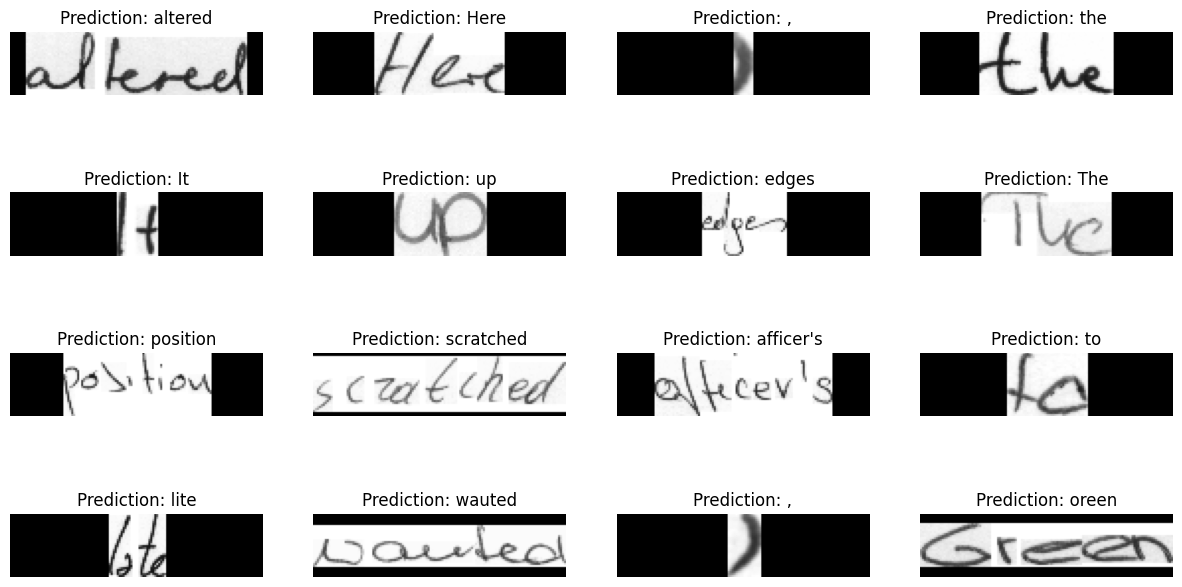

In [42]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    output_text = []

    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
        output_text.append(res)

    return output_text

for batch in test_ds.take(1):
    batch_images = batch["image"]
    print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap = "gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

    plt.show()

In [43]:
custom_objects = {"CTCLayer": CTCLayer}

In [44]:
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/OCR/Hand writting detection/ocr_model_50_epoch.h5", custom_objects=custom_objects)

In [45]:
prediction_model = keras.models.Model(
  reconstructed_model.get_layer(name="image").input, reconstructed_model.get_layer(name="dense2").output
)

(64, 128, 32, 1)
2/2 [==============================] - 2s 10ms/step


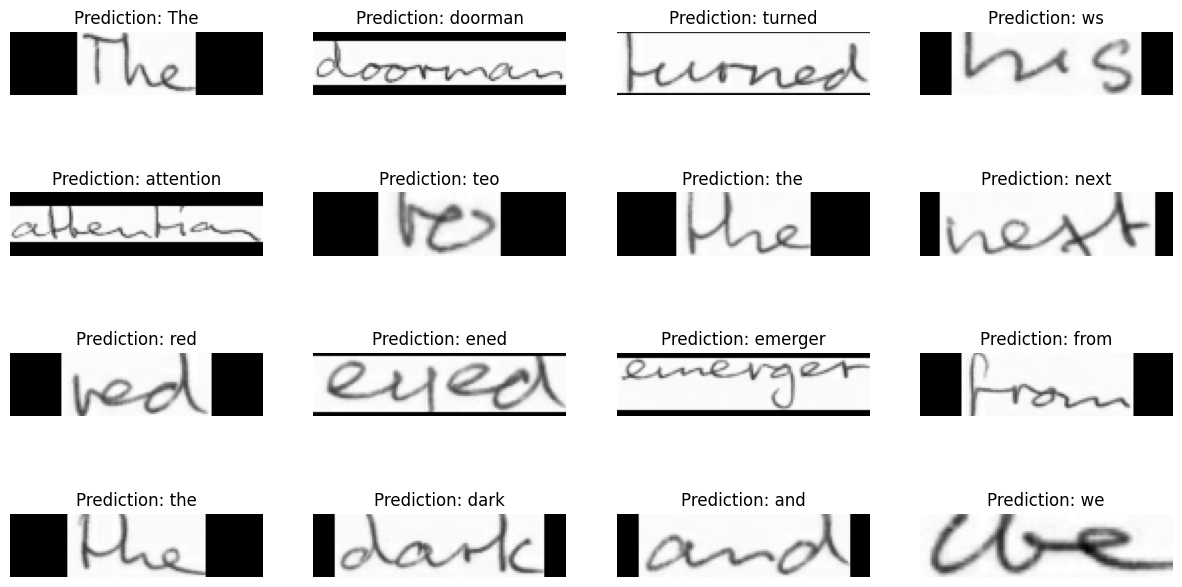

(18, 128, 32, 1)
1/1 [==============================] - 3s 3s/step


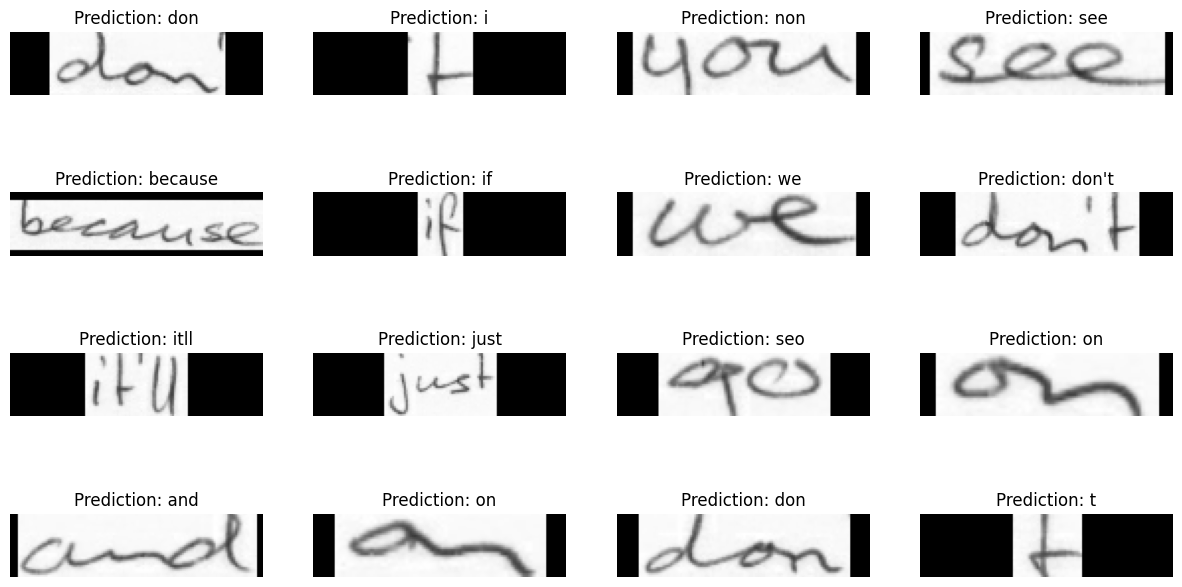

In [46]:
# Test on New set of images
pred_test_text = []

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    output_text = []

    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
        output_text.append(res)

    return output_text

for batch in inf_images.take(3):
    batch_images = batch["image"]
    print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    pred_test_text.append(pred_texts)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap = "gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

    plt.show()

In [47]:
flat_list = [item for sublist in pred_test_text for item in sublist]
print(flat_list)

['The', 'doorman', 'turned', 'ws', 'attention', 'teo', 'the', 'next', 'red', 'ened', 'emerger', 'from', 'the', 'dark', 'and', 'we', 'went', 'an', 'toaether', 'to', 'the', 'station', 'the', 'children', 'silent', 'because', 'of', 'the', 'cruelty', 'of', 'the', 'world', 'Finally', 'Catherine', 'sad', 'her', 'eyes', 'wet', 'agan', 'think', 'its', 'all', 'abolutely', 'beastlyy', 'and', ',', 'can', 'It', 'bear', 'tothink', 'about', 'it', 'And', 'P', 'hilip', 'sad', 'But', 'we', 'we', 'aot', 'to', 'think', 'about', 'it', 'don', 'i', 'non', 'see', 'because', 'if', 'we', "don't", 'itll', 'just', 'seo', 'on', 'and', 'on', 'don', 't', 'non', 'see']


In [48]:
sentence = ' '.join(flat_list)
print(sentence)

The doorman turned ws attention teo the next red ened emerger from the dark and we went an toaether to the station the children silent because of the cruelty of the world Finally Catherine sad her eyes wet agan think its all abolutely beastlyy and , can It bear tothink about it And P hilip sad But we we aot to think about it don i non see because if we don't itll just seo on and on don t non see
